<a href="https://colab.research.google.com/github/nhathpham/Taxi-Fleet-Management/blob/main/trip_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Goals**
- Identify patterns that indicate potential high-demand areas and times
- Identify patterns that indicate different types of taxi trips (short urban commute, airport trips, late night trip from entertainment area etc.)



# **1. Load dataset**

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from folium import Choropleth

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to your Parquet file
file_path = '/content/drive/My Drive/USML Projects/Data/clean_data_0213.parquet'
df = pd.read_parquet(file_path)
len(df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1597812

## **Change some data format so it is easier to visualize**

In [ ]:
# Demand throughout the day for each neighborhood (when and where to allocate taxi)
df['day_id'] = df['trip_start_timestamp'].dt.date

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Convert 'dow' (day of week) in 'df' to a categorical type with the defined order
df['dow'] = pd.Categorical(df['dow'], categories=day_order, ordered=True)

period_order = ['Early Morning', 'Morning Rush', 'Midday', 'Afternoon', 'Evening Rush', 'Evening','Night']
# Convert 'period_start' in 'df' to a categorical type with the defined order
df['period_start'] = pd.Categorical(df['period_start'], categories=period_order, ordered=True)

#df1 = df[df.record_error == False]
df2 = df[df.dropoff_location.notnull()]

df['pickup_community_area'] = df['pickup_community_area'].astype('int')
df2['dropoff_community_area'] = df2['dropoff_community_area'].astype(int)

In [ ]:
df1=df.copy()
df.head()
# Define a mapping of original column names to shorter names
column_mapping = {
    'unique_key': 'trip_id',
    'trip_start_timestamp': 'start_time',
    'trip_end_timestamp': 'end_time',
    'trip_seconds': 'duration',
    'trip_miles': 'distance',
    'pickup_ca_name': 'pickup_area',
    'dropoff_ca_name': 'dropoff_area',
    'fare': 'fare',
    'tips':'tips',
    'pickup_latitude': 'pickup_lat',
    'pickup_longitude': 'pickup_lon',
    'dropoff_latitude': 'dropoff_lat',
    'dropoff_longitude': 'dropoff_lon',
    'record_error':'is_error'
}
# Rename the columns of df_op using the mapping
df1.rename(columns=column_mapping, inplace=True)


In [ ]:
df1[['trip_id','start_time','end_time','period_start','duration','distance','pickup_area','dropoff_area','fare','tips','pickup_lat','pickup_lon','dropoff_lat','dropoff_lon','is_error']].head()

,trip_id,start_time,end_time,period_start,duration,distance,pickup_area,dropoff_area,fare,tips,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,is_error
0,9e805296dc64928e9766a98bc9337fbf8b933d75,2023-10-06 09:30:00,2023-10-06 09:30:00,Morning Rush,639.0,1.41,Near North Side,Near North Side,8.00,0.00,41.909496,-87.630964,41.895033,-87.619711,False
1,9d25380e55aec4162fb8cb6938e66c71f5599cc5,2023-10-20 11:30:00,2023-10-20 11:30:00,Midday,509.0,1.66,Near North Side,Loop,7.75,2.00,41.900221,-87.629105,41.880994,-87.632746,False
2,9adfb855a4e5465ebddeac182ee561a328eb0c86,2023-10-01 11:30:00,2023-10-01 12:00:00,Midday,1688.0,9.65,Ashburn,Roseland,27.00,0.00,41.745758,-87.708366,41.706588,-87.623367,False
3,9a679dc37796cc45390cf13cf93ec1dc927eb35d,2023-10-06 06:15:00,2023-10-06 06:30:00,Early Morning,1021.0,6.04,Rogers Park,Lake View,16.75,4.13,42.009623,-87.670167,41.944227,-87.655998,False
4,9fb21f2b4891a4575512aa647507d5ef1e91727e,2023-10-08 10:15:00,2023-10-08 10:45:00,Midday,1008.0,10.54,Fuller Park,Calumet Heights,27.75,0.00,41.809084,-87.632425,41.729676,-87.572717,False



# **1. Temporal analysis**
## **1.1 Trip frequencies over time**
*Identify high demand times*

- Daily trip counts show cyclical fluctuations -> possible weekly trends.
- Trip frequency peaks during evening rush hours, particularly between 6 PM and 8 PM, corresponding to typical office commute times. Trip counts decrease gradually at night.
- Weekday trip volumes remain relatively stable, with a slight dip on Fridays.
- Weekend trips significantly decline, potentially due to increased local leisure activities, reduced workplace commutes, and alternative transportation preferences such as walking, cycling, or public transit.

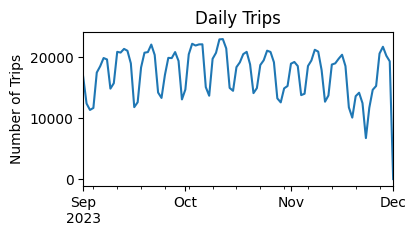

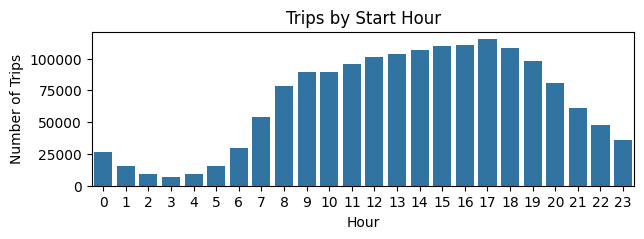

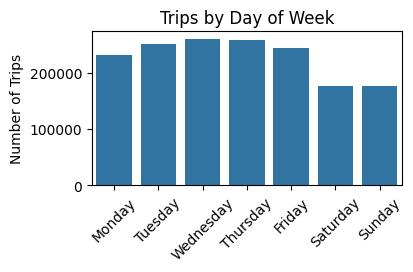

In [ ]:
# Daily trips - trends, seasonality, and anomalies in trip frequencies.
plt.figure(figsize=(4, 2))
df.resample('D', on='trip_start_timestamp').size().plot()
plt.title('Daily Trips')
plt.ylabel('Number of Trips')
plt.xlabel('')
plt.show()

# Trips by start hour: - Identify peak demand times
plt.figure(figsize=(7, 2))
sns.countplot(x=df['hour'])
plt.title('Trips by Start Hour')
plt.ylabel('Number of Trips')
plt.xlabel('Hour')
plt.xticks(rotation=0)
plt.show()

# Define the order of the days of the week

# Plot the countplot with the specified order: - Identify peak demand days
plt.figure(figsize=(4, 2))
sns.countplot(x=df['dow'], order=day_order)
plt.title('Trips by Day of Week')
plt.ylabel('Number of Trips')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show()


## **1.2 Trip demand by time period and by day of week**
*Identify peak times/ high demand times and locations*
- Highest demand during Morning Rush period across all weekdays, drop on weekends
- Weekday demand has a consistent pattern: higher trip counts during commuting hours (Morning Rush and Evening Rush), and significant drop during Late Evening and Late Night
- On weekend, distribution is more even throughout the day, but overall demand is lower
- Lowest demand is in Early Morning in all days, then Late Night
- Evening and Late Evening trips are lower on Sundays and Mondays, and higher close to the weekend (Thuday, Friday)

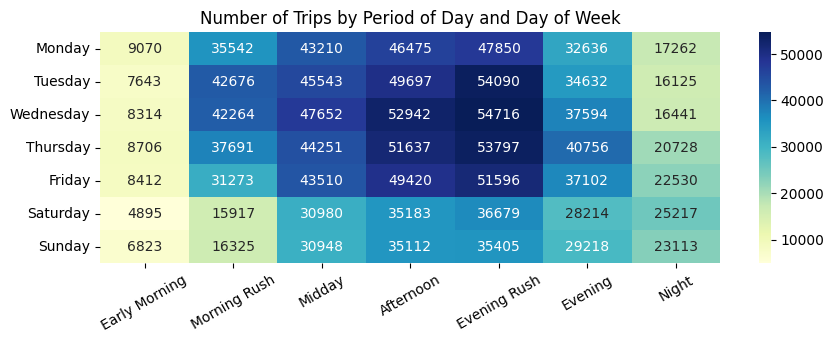

In [ ]:
# Create a pivot table of the number of trips by hour and day of week
trips_pivot = df.pivot_table(index="dow", columns="period_start", values="unique_key", aggfunc=len)

# Plot the pivot table as a heatmap
plt.figure(figsize=(10,3))
sns.heatmap(trips_pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Number of Trips by Period of Day and Day of Week")
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation = 30)
plt.show()

In [ ]:
df.period_start.unique()


['Morning Rush', 'Midday', 'Early Morning', 'Afternoon', 'Evening Rush', NaN, 'Evening']
Categories (8, object): ['Early Morning' < 'Morning Rush' < 'Midday' < 'Afternoon' < 'Evening Rush' <
                         'Evening' < 'Late Evening' < 'Late Night']

In [ ]:
len(df[df.period_start.isna()])

141416

# **2. Spatial analysis**
## **2.1 Choropleth maps to show high-demand locations**
- Top 5 pickup areas: Ohare, Near north side, Loop, Near West Side, Garfield Ridge, Near south side, (Lake View, Lincoln Park)
- Top 5 dropoff areas: Near north side, Loop, Near West Side, Ohare, Lake View, (Near south side, Lincoln Park)
- High traffic & demand at key transit (airport), commercial, and tourist areas
  + Near North Side: Affluent residential and commercial area, known for its shopping districts, dining, and nightlife.
  + Loop: Chicago's central business district, characterized by high-rise buildings, financial institutions, and cultural venues.
  + Near West Side: Diverse mix of residential areas, medical centers, and university campuses, with growing entertainment districts.
  + Garfield Ridge: Residential neighborhood known for its proximity to Midway International Airport and a large industrial park.
  + Near South Side: Rapidly developing area with a mix of residential, commercial, and cultural attractions, including museums and stadiums.
  + Lake View: A bustling neighborhood known for Wrigley Field, entertainment, and lakeside recreation.
  + Lincoln Park: Affluent area noted for its namesake park, DePaul University, and upscale living with vibrant commercial corridors.
  + Uptown: Historic entertainment district with cultural diversity and a vibrant mix of music venues and nightlife.
  + West Town: Trendy, artistic neighborhood with galleries, unique shops, and diverse dining options.

In [ ]:
# File path
file_path = '/content/drive/My Drive/USML Projects/Nhat/chicago_ca.geojson'

# Read the GeoJSON file
with open(file_path, 'r') as f:
    geojson_data = json.load(f)

# Convert GeoJSON features to DataFrame
geojson_features = geojson_data['features']
geojson_df = pd.DataFrame([feature['properties'] for feature in geojson_features])
geojson_df['area_num_1'] = geojson_df['area_num_1'].astype(int)
#geojson_df.head(2)

In [ ]:
geojson_df.head()

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503
3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573
4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062


In [ ]:
def create_choro(df, geojson_df, map_col):
  # Merge GeoJSON data with your data based on the community area number
  merged_data = pd.merge(left=df, right=geojson_df, how='inner', left_on=map_col, right_on='area_num_1')

  # Count number of records for each community area
  counts_per_area = merged_data[map_col].value_counts().reset_index()
  counts_per_area.columns = [map_col, 'count']

  # Create a map centered at the mean of pickup locations
  map_center = [merged_data['pickup_latitude'].mean(), merged_data['pickup_longitude'].mean()]
  m = folium.Map(location=map_center, zoom_start=11)

  # Add choropleth layer for community areas
  choropleth = Choropleth(
      geo_data=geojson_data,
      name='choropleth',
      data=counts_per_area,
      columns=[map_col, 'count'],
      key_on='feature.properties.area_num_1',
      fill_color='YlGnBu',
      fill_opacity=0.7,
      line_opacity=0.2,
      legend_name='Number of Records per Community Area',
      bins=9  # Number of color levels
  ).add_to(m)
  # Add popup with area name to each feature
  for _, row in counts_per_area.iterrows():
      folium.GeoJsonTooltip(fields=['community'], labels=False).add_to(choropleth.geojson)
  # Display the map
  #m.save('pickup_choro2.html')
  return m, counts_per_area

m_pickup, counts_pickup = create_choro(df, geojson_df, 'pickup_community_area')
m_pickup

In [ ]:
# top 5 CA for pickup
counts_pickup = counts_pickup.merge(geojson_df[['community', 'area_num_1']], left_on='pickup_community_area', right_on='area_num_1', how='left').drop(columns='area_num_1')
counts_pickup.head()

,pickup_community_area,count,community
0,76,379361,OHARE
1,8,350608,NEAR NORTH SIDE
2,32,275446,LOOP
3,28,145222,NEAR WEST SIDE
4,56,64398,GARFIELD RIDGE


In [ ]:
m_dropoff, counts_dropoff = create_choro(df2, geojson_df, 'dropoff_community_area')
#m_dropoff
counts_dropoff = counts_dropoff.merge(geojson_df[['community', 'area_num_1']], left_on='dropoff_community_area', right_on='area_num_1', how='left').drop(columns='area_num_1')
counts_dropoff.head(7)

,dropoff_community_area,count,community
0,8,380755,NEAR NORTH SIDE
1,32,272755,LOOP
2,28,149269,NEAR WEST SIDE
3,76,108075,OHARE
4,6,69248,LAKE VIEW
5,33,67752,NEAR SOUTH SIDE
6,7,61587,LINCOLN PARK


## **2.2 Top 10 popular pickup/dropoff community areas**

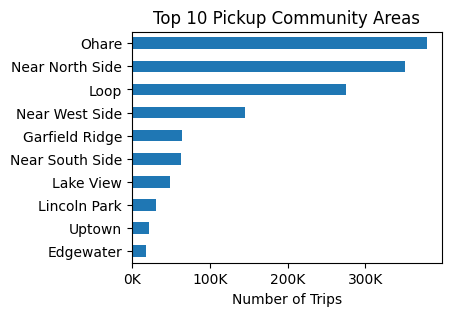

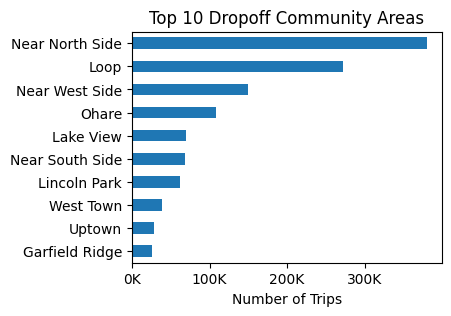

In [ ]:
# Top community areas for pickups
plt.figure(figsize=(4, 3))
pickup_areas = df['pickup_ca_name'].value_counts().head(10).iloc[::-1]
ax = pickup_areas.plot(kind='barh')
# Simplify the x-axis label formatting
ax.set_xticklabels([f'{round(x/1000)}K' for x in ax.get_xticks()])
plt.title('Top 10 Pickup Community Areas')
plt.xlabel('Number of Trips')
plt.ylabel('')
plt.show()


# Top community areas for dropoffs
plt.figure(figsize=(4, 3))
pickup_areas = df['dropoff_ca_name'].value_counts().head(10).iloc[::-1]
ax = pickup_areas.plot(kind='barh')
ax.set_xticklabels([f'{round(x/1000)}K' for x in ax.get_xticks()])
plt.title('Top 10 Dropoff Community Areas')
plt.xlabel('Number of Trips')
plt.ylabel('')
plt.show()

# **3. Demand analysis**

### **3.1 Trip demand by time period and by region**
*Identify peak times/ high demand times and locations*
- The Loop, Near North Side, and O'Hare show significantly higher median trip numbers, particularly during Evening Rush, Afternoon, and Midday periods. OHare has the highest median during Evening
- Late Evening and Late Night periods show universally lower median trip numbers, with several community areas experiencing little to no taxi trips.

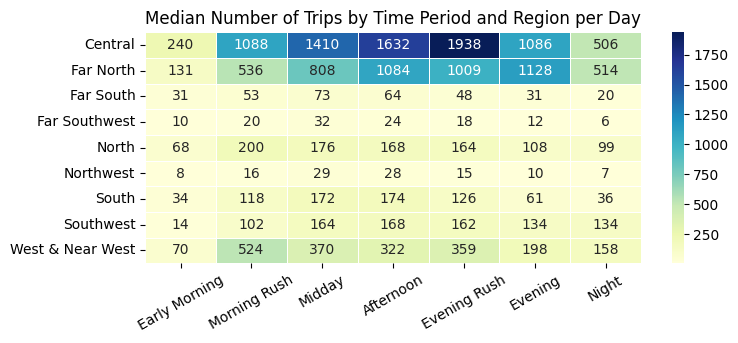

In [ ]:
df['pickup_region'] = df['pickup_region'].replace('Central, Near North, & Near South', 'Central')

# Step 2: Group the data by 'day_id', 'period_start', and 'pickup_community_area' and count trips
daily_trip_counts = df.groupby(['day_id', 'period_start', 'pickup_region']).size().reset_index(name='trip_count')

# Step 3: Calculate the median trip count for each 'period_start' and 'pickup_community_area'
avg_trip_counts = daily_trip_counts.groupby(['pickup_region', 'period_start'])['trip_count'].median().reset_index()

# Step 4: Pivot the data for the heatmap
pivot_table = avg_trip_counts.pivot("pickup_region", "period_start", "trip_count")

# Step 5: Plot the heatmap
plt.figure(figsize=(8, 3))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt=".0f", linewidths=.5)  # 'annot=True' to display counts, adjust 'fmt' as needed
plt.title('Median Number of Trips by Time Period and Region per Day')
plt.xlabel('')
plt.xticks(rotation=30)
plt.ylabel('')
plt.show()


## **3.2 Trip demand by time period and by community area**

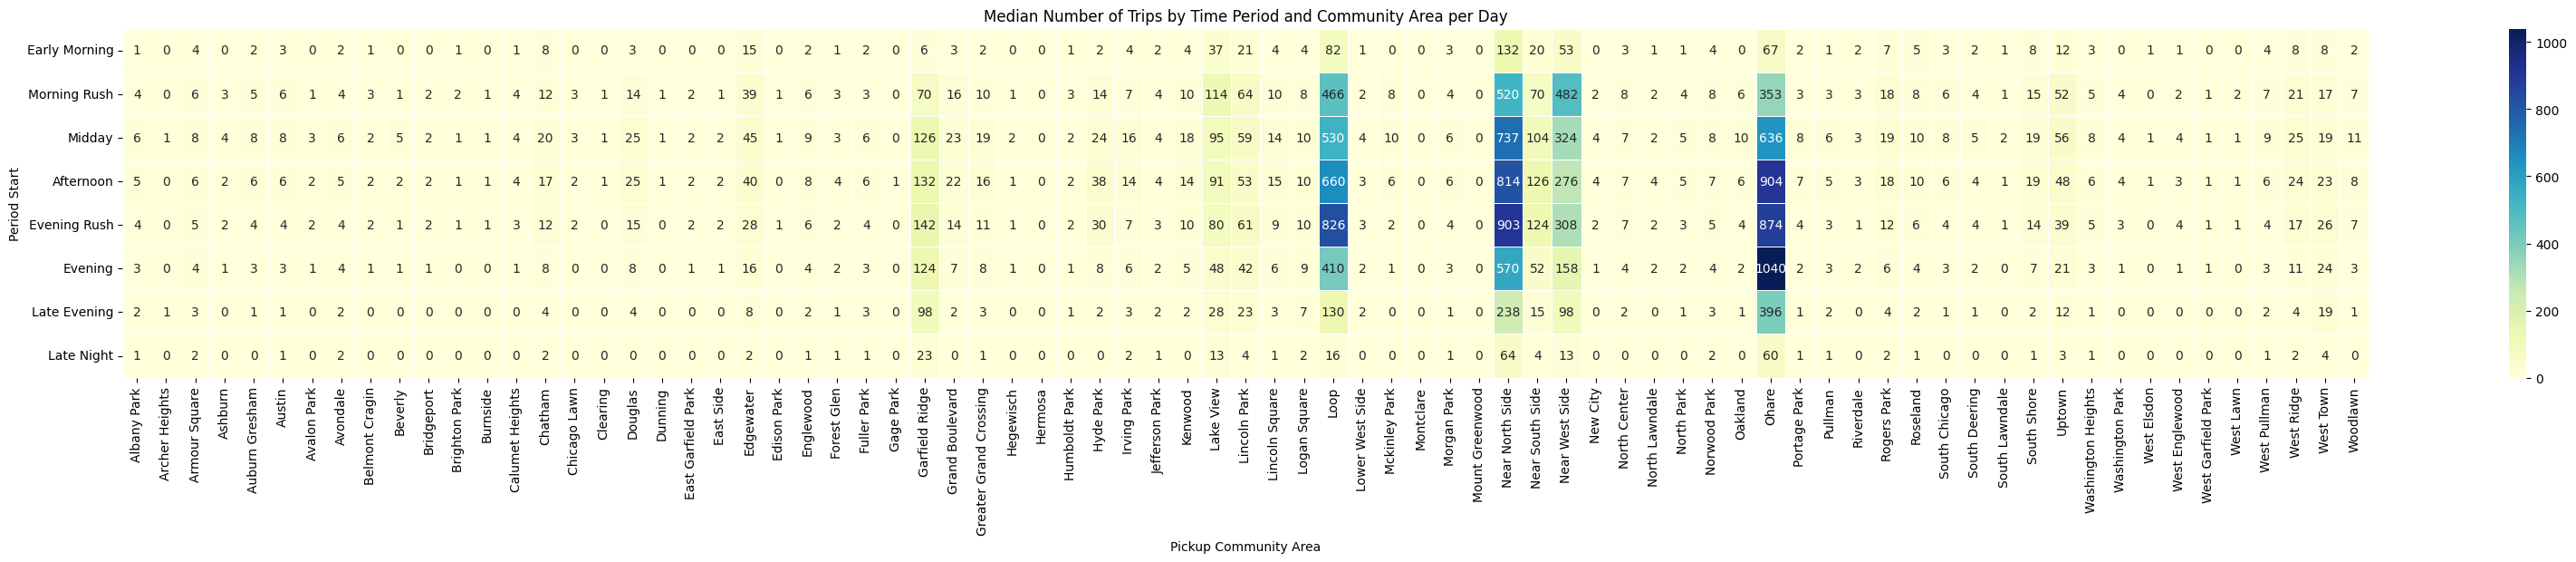

In [ ]:
# Step 2: Group the data by 'day_id', 'period_start', and 'pickup_community_area' and count trips
daily_trip_counts = df.groupby(['day_id', 'period_start', 'pickup_ca_name']).size().reset_index(name='trip_count')

# Step 3: Calculate the median trip count for each 'period_start' and 'pickup_community_area'
avg_trip_counts = daily_trip_counts.groupby(['period_start', 'pickup_ca_name'])['trip_count'].median().reset_index()

# Step 4: Pivot the data for the heatmap
pivot_table = avg_trip_counts.pivot("period_start", "pickup_ca_name", "trip_count")

# Step 5: Plot the heatmap
plt.figure(figsize=(40, 5))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt=".0f", linewidths=.5)  # 'annot=True' to display counts, adjust 'fmt' as needed
plt.title('Median Number of Trips by Time Period and Community Area per Day')
plt.xlabel('Pickup Community Area')
plt.ylabel('Period Start')
plt.show()

# **4. Trip pattern analysis**

## **4.1 Correlation**
- *Hypothesis: if we see trip attributes correlate with time of day/ dow, we can identify patterns in demand intensity (eg. longer trips/ higher costs more common during the weekend, short trips during evening hours)*
- **Very weak/ no correlation between trip attributes (cost, length) and timing (day of week or time of day) or region**
- Correlation between tips and payment_type is not meaningful, because cash tips are not recorded (the dataset does not accurately reflect the entire tipping behavior of people)

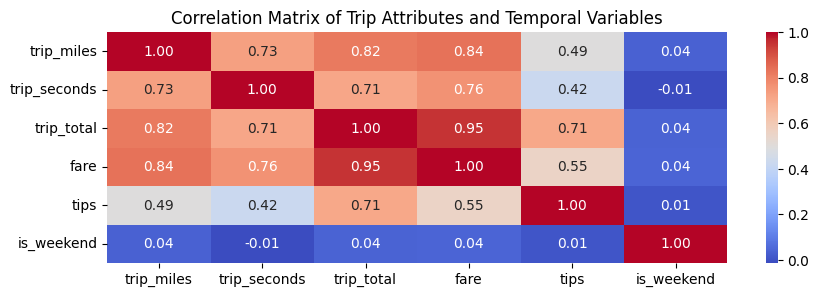

In [ ]:
# Selecting relevant columns for correlation analysis
relevant_columns = ['trip_miles', 'trip_seconds', 'trip_total', 'fare', 'tips','is_weekend'] #'dow','period_start','region'
df_selected = df[relevant_columns]

# Convert 'hour_of_day' and 'day_of_week' to categorical and get dummy variables for correlation analysis
#df_selected = pd.get_dummies(df_selected, columns=['payment_type'])

# Calculating correlation matrix
correlation_matrix = df_selected.corr()

# Visualizing the correlation matrix using seaborn
plt.figure(figsize=(10, 3))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Trip Attributes and Temporal Variables')
plt.show()

## **4.2 Distribution of attributes**
*Reveal common trip length/ duration -> prevalent trip types*
- Fare: right-skewed with a large number of trips costing relatively low fares.
There are several peaks, suggesting common fare amounts or standard charges.
- Trip total: broader spread compared to the fare, likely due to additional costs like tips and tolls.
- Tips: most trips having low to no tips.The distribution drops sharply, showing that higher tips are much less common.
- Extras: not commonly applied or are generally low in cost.
- Trip miles: most trips are short with fewer long-distance trips. There are small peaks at regular intervals, which may represent standard trip lengths or popular destinations.
- Trip seconds: most trips are short in duration.
- Avg Speed (ERROR REMOVED): appears normally distributed, centered around a peak that suggests a common average speed.

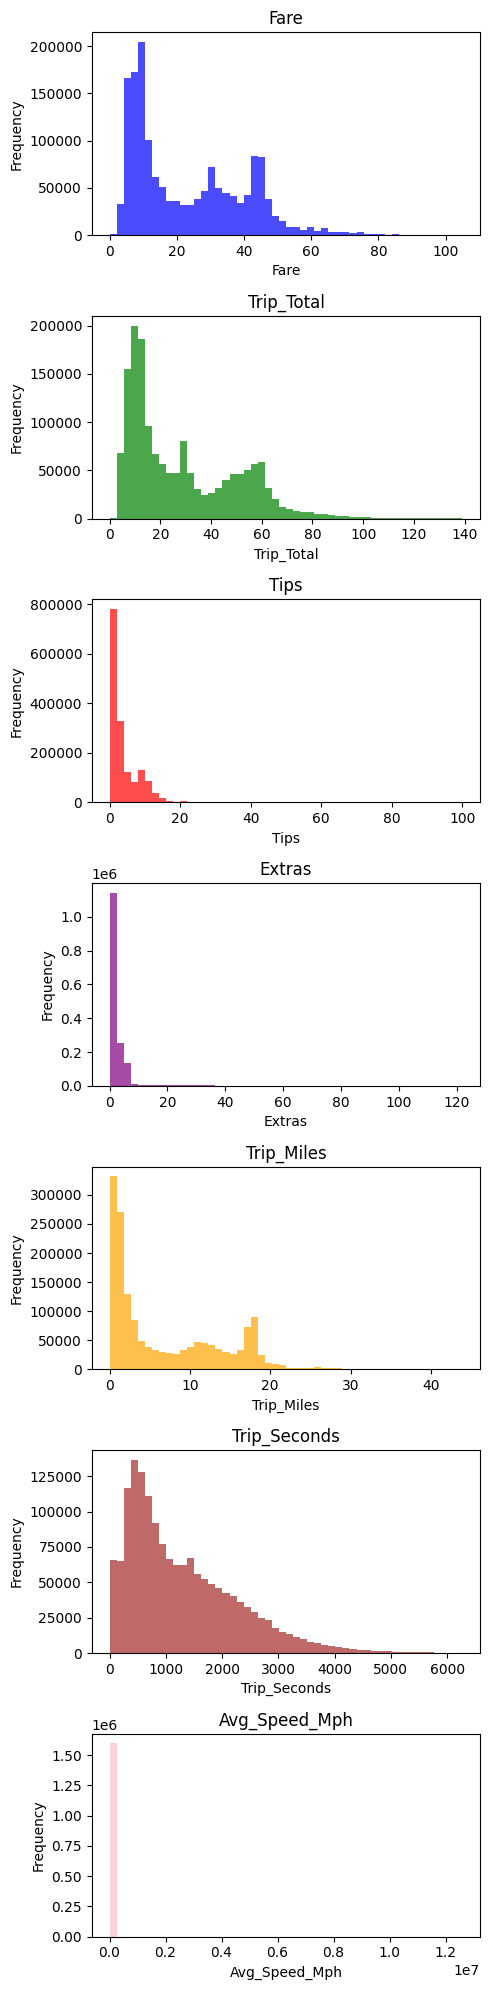

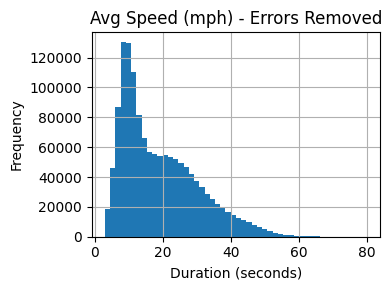

In [ ]:
# Create a figure with 7 subplots
fig, axs = plt.subplots(7, figsize=(5,20))

# List of columns to plot
columns = ['fare', 'trip_total','tips','extras', 'trip_miles', 'trip_seconds', 'avg_speed_mph']
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']

# Plot histogram for each column
for i, column in enumerate(columns):
    axs[i].hist(df[column], bins=50, color=colors[i], alpha=0.7)
    axs[i].set_title(f'{column.title()}')
    axs[i].set_xlabel(column.title())
    axs[i].set_ylabel('Frequency')

# Display the plots
plt.tight_layout()
plt.show()

# Histograms of trip_seconds and trip_miles
plt.figure(figsize=(4, 3))
df1['avg_speed_mph'].hist(bins=50)
plt.title('Avg Speed (mph) - Errors Removed')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


## **4.3 Speed**
*Average speed against time of day or dow can indicate periods of high traffic congestion or faster travel times --> trip patterns related to urban commute versus leisure travel.*

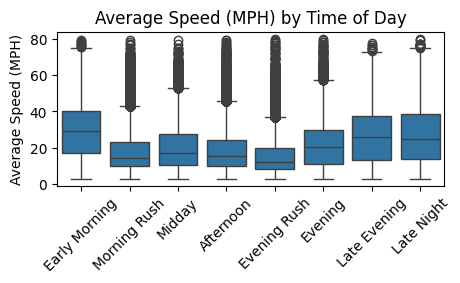

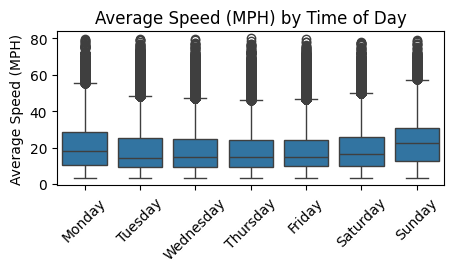

In [ ]:
# Boxplot of average speed by time of day
plt.figure(figsize=(5, 2))
sns.boxplot(x='period_start', y='avg_speed_mph', data=df1, order=period_order)
plt.title('Average Speed (MPH) by Time of Day')
plt.xlabel('')
plt.ylabel('Average Speed (MPH)')
plt.xticks(rotation=45)
plt.show()

# Boxplot of average speed by time of day
plt.figure(figsize=(5, 2))
sns.boxplot(x='dow', y='avg_speed_mph', data=df1, order=day_order)
plt.title('Average Speed (MPH) by Time of Day')
plt.xlabel('')
plt.ylabel('Average Speed (MPH)')
plt.xticks(rotation=45)
plt.show()

## **4.4 Costs**
### **a. Fare**
- Lowest Median Fares in Weekday rush hours: Commuter trips are likely shorter and more frequent
- Highest median fares generally occurring during the Early Morning and Late Night periods across all weekdays: Fewer taxis available leading to surge pricing, longer trips common due to lack of public transport options, or standard night-time surcharges.
- Higher Sunday Daytime Fares: Reflects leisure or travel-related trips, which are typically longer as people may be returning from weekend outings or visiting different parts of the city.
- Lower Friday and Saturday Evening Fares: Social outings may involve shorter trips within entertainment districts.
- Higher Fares on Sunday and Monday Evenings: Could indicate fewer taxis available, or longer trips at the start of the workweek and end of the weekend.

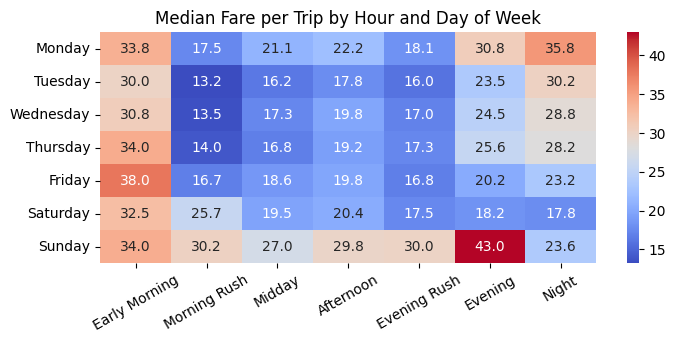

In [ ]:
# Create a pivot table of the average fare by hour and day of week
fare_pivot = df.pivot_table(index="dow", columns="period_start", values="trip_total", aggfunc=np.median)

# Plot the pivot table as a heatmap
plt.figure(figsize=(8,3))
sns.heatmap(fare_pivot, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Median Fare per Trip by Hour and Day of Week")
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=30)
plt.show()

### **b. Fare per mile**
*Economic value of trips at different times or in different areas, supporting the identification of potentially underserved or overpriced segments.*
- Fare per mile higher during the Early Morning and Late Night -> trips are either longer in distance or there's a surcharge applied during these off-peak hours.
- Central neighborhoods (Loop, Near North Side, and Near West Side) have a significantly higher median fare per mile: shorter trips within a dense urban core, which are priced higher per mile.
- O'Hare has the lowest rate per mile: Airport trips often involve longer distances with flat-rate or discounted pricing structures, resulting in a lower fare per mile


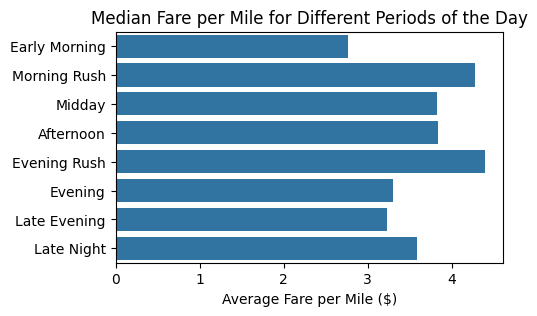

In [ ]:
# Calculate fare per mile
df['fare_per_mile'] = df['fare'] / df['trip_miles']

# Group by period_start and calculate the mean fare per mile
med_fpm_period = df.groupby('period_start')['fare_per_mile'].median().reset_index()
# Sort the periods by the average fare per mile
med_fpm_period = med_fpm_period.sort_values('fare_per_mile')
# Plotting
plt.figure(figsize=(5, 3))
sns.barplot(x='fare_per_mile', y='period_start', data=med_fpm_period) #, palette='viridis'
plt.xlabel('Average Fare per Mile ($)')
plt.ylabel('')
plt.title('Median Fare per Mile for Different Periods of the Day')
plt.show()

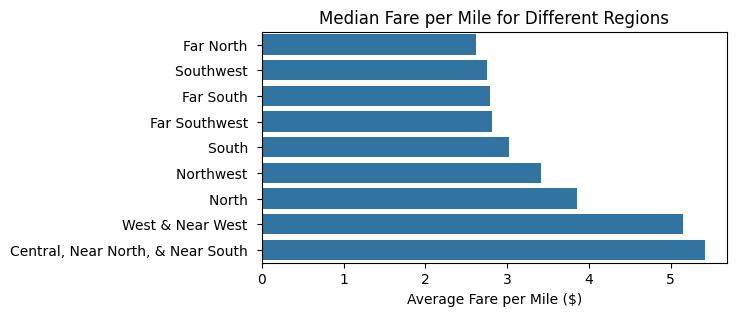

In [ ]:
# Group by period_start and calculate the mean fare per mile
med_fpm_ca = df.groupby('pickup_region')['fare_per_mile'].median().reset_index()
# Sort the periods by the average fare per mile
med_fpm_ca = med_fpm_ca.sort_values('fare_per_mile')
# Plotting
plt.figure(figsize=(6, 3))
sns.barplot(x='fare_per_mile', y='pickup_region', data=med_fpm_ca) #, palette='viridis'
plt.xlabel('Average Fare per Mile ($)')
plt.ylabel('')
plt.title('Median Fare per Mile for Different Regions')
plt.show()


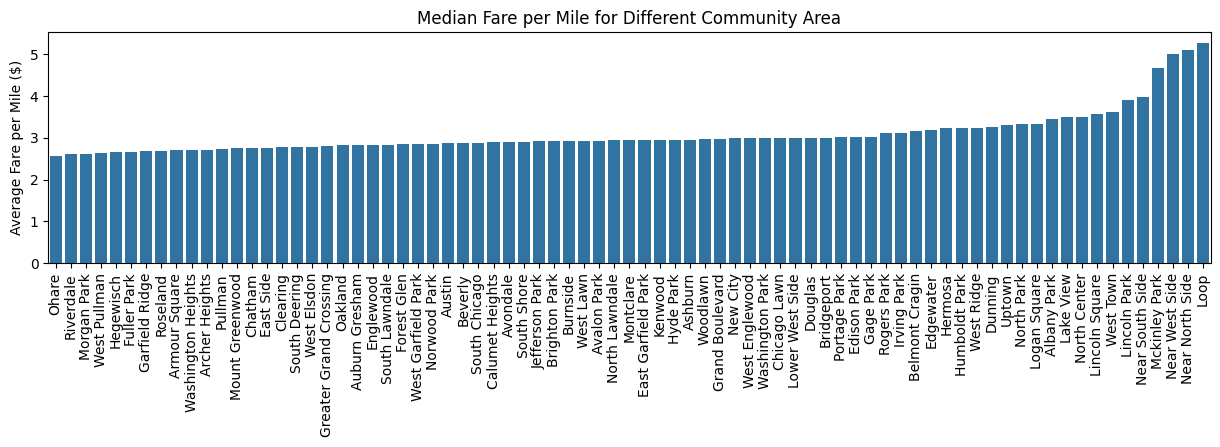

In [ ]:
# Calculate fare per mile
df1['fare_per_mile'] = df1['fare'] / df1['trip_miles']

# Group by period_start and calculate the mean fare per mile
med_fpm_ca = df1.groupby('pickup_ca_name')['fare_per_mile'].median().reset_index()
# Sort the periods by the average fare per mile
med_fpm_ca = med_fpm_ca.sort_values('fare_per_mile')
# Plotting
plt.figure(figsize=(15, 3))
sns.barplot(x='pickup_ca_name', y='fare_per_mile', data=med_fpm_ca) #, palette='viridis'
plt.xlabel('')
plt.ylabel('Average Fare per Mile ($)')
plt.title('Median Fare per Mile for Different Community Area')
plt.xticks(rotation=90)
plt.show()


In [ ]:
#df[(df.pickup_ca_name=='Mckinley Park') & (df.record_error==True)].head()

### **c. Distribution of payment type**

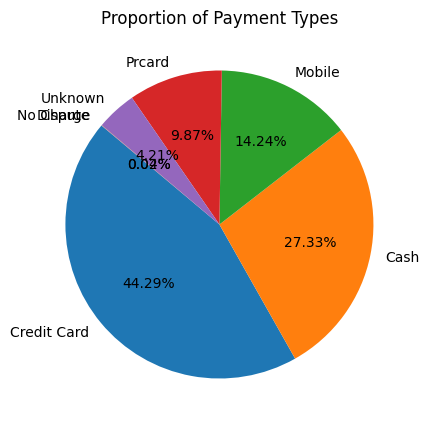

In [ ]:
# Calculate the proportion of each payment type
payment_type_proportions = df['payment_type'].value_counts(normalize=True)
# Create a pie chart
plt.figure(figsize=(5, 5))
plt.pie(payment_type_proportions, labels=payment_type_proportions.index, autopct='%1.2f%%', startangle=140)
plt.title('Proportion of Payment Types')
plt.show()

### **d. Company**
- Taxi Affliation Services have significantly more records with potential recording errors than other companies

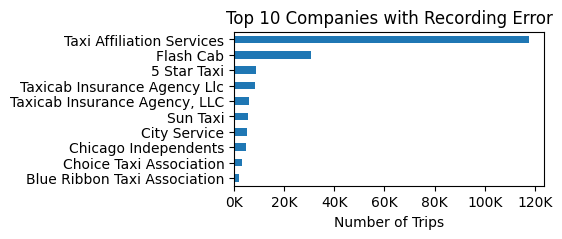

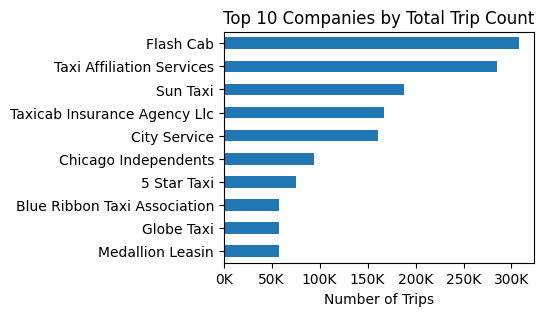

In [ ]:
# Companies with lots of recording error
plt.figure(figsize=(4, 2))
pickup_areas = df[df.record_error==True]['company'].value_counts().head(10).iloc[::-1]
ax = pickup_areas.plot(kind='barh')
# Simplify the x-axis label formatting
ax.set_xticklabels([f'{round(x/1000)}K' for x in ax.get_xticks()])
plt.title('Top 10 Companies with Recording Error')
plt.xlabel('Number of Trips')
plt.ylabel('')
plt.show()


# Companies with lots of recording error
plt.figure(figsize=(4, 3))
pickup_areas = df['company'].value_counts().head(10).iloc[::-1]
ax = pickup_areas.plot(kind='barh')
ax.set_xticklabels([f'{round(x/1000)}K' for x in ax.get_xticks()])
plt.title('Top 10 Companies by Total Trip Count')
plt.xlabel('Number of Trips')
plt.ylabel('')
plt.show()